Q1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
# Load the dataset
data_path = './datasets/regression_data_multilinear_group_12_train.txt'

# Adjusting the data loading process to skip the header row
data = np.loadtxt(data_path, skiprows=1)
np.random.seed(42)  # For reproducibility
np.random.shuffle(data)  # Randomly shuffle the data

# Separate features and targets again
X = data[:, :10]  # Features (sensor readings)
y = data[:, 10:]  # Targets (y1, y2, y3 positions)

split_idx1 = int(X.shape[0] * 0.6)
split_idx2 = split_idx1 + int((X.shape[0] - split_idx1) * 0.5)

X_train = X[:split_idx1]
X_val = X[split_idx1:split_idx2]
X_test = X[split_idx2:]
y_train = y[:split_idx1]
y_val = y[split_idx1:split_idx2]
y_test = y[split_idx2:]

mean_X = np.mean(X_train, axis=0)
std_dev_X = np.std(X_train, axis=0) 
norm2_X = np.linalg.norm(X_train, axis=0)

mean_y = np.mean(y_train, axis=0)
std_dev_y = np.std(y_train, axis=0)
norm2_y = np.linalg.norm(y_train, axis=0)

X_train_norm_2 = X_train / norm2_X
y_train_norm_2 = y_train / norm2_y

X_val_norm_2 = X_val / norm2_X
y_val_norm_2 = y_val / norm2_y

X_test_norm_2 = X_test / norm2_X
y_test_norm_2 = y_test / norm2_y

X_train_norm_zs = (X_train - mean_X) / std_dev_X
y_train_norm_zs = (y_train - mean_y) / std_dev_y

X_val_norm_zs = (X_val - mean_X) / std_dev_X
y_val_norm_zs = (y_val - mean_y) / std_dev_y

X_test_norm_zs = (X_test - mean_X) / std_dev_X
y_test_norm_zs = (y_test - mean_y) / std_dev_y

def phi_x(X):
    return np.c_[X, np.ones((X.shape[0], 1))]

In [3]:
def get_theta(X, y):
    # Add a bias term (column of ones) to X for the intercept
    X_b = phi_x(X)

    # Solve the normal equation again: theta = (X_b.T * X_b)^(-1) * X_b.T * y
    theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    return theta

In [4]:
def print_poly(theta, norm=""):
    m, n = theta.shape
    norm = "_"+norm if norm != "" else ""
    for i in range(n):
        poly = ""

        for j in range(m):

            poly += f"{theta[j][i]:.4f}*X{j+1}{norm} + "

        print(poly + f"{theta[j][i]:.4f} = y{i+1}{norm}'")

In [5]:
# Recalculating the Pearson Correlation, MSE, and MAE using only numpy

# Function to calculate Pearson Correlation Coefficient
def pearson_correlation(actual, predicted):
    numerator = np.sum((actual - np.mean(actual)) *
                       (predicted - np.mean(predicted)))
    denominator = np.sqrt(np.sum((actual - np.mean(actual))**2)
                          * np.sum((predicted - np.mean(predicted))**2))
    return numerator / denominator

# Function to calculate Mean Squared Error

def root_mean_squared_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Function to calculate Mean Absolute Error
def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))


In [6]:
def get_metrics(y, y_pred):

    # Calculating Pearson Correlation for each target
    pearson_corr = np.array([pearson_correlation(y[:, i], y_pred[:, i]) for i in range(y.shape[1])])

    # Calculating MSE and MAE for each target
    rmse = np.array([root_mean_squared_error(y[:, i], y_pred[:, i])
                    for i in range(y.shape[1])])
    mae = np.array([mean_absolute_error(y[:, i], y_pred[:, i])
                    for i in range(y.shape[1])])

    return pearson_corr, rmse, mae

In [7]:
lookup_table_refined = {
    0.05: 1.960,  # Critical value for p = 0.05
    0.01: 2.576,  # Critical value for p = 0.01
    0.001: 3.291  # Critical value for p = 0.001
}

In [8]:
def plot_y(X, y, theta, norm=""):
   # Adjusting the correlation plots to include the best fit line and y=x line
    X_b = phi_x(X)
    y_pred = np.matmul(X_b, theta)

    pc, rmse, mae = get_metrics(y, y_pred)

    plt.figure(figsize=(10, 15))

    for i in range(y.shape[1]):
        # Scatter plot for actual vs predicted
        plt.subplot(3, 1, i+1)
        plt.scatter(y[:, i], y_pred[:, i], alpha=0.5,
                    color='green', marker='x')

        # Best fit line (red line)
        m, b = np.polyfit(y[:, i], y_pred[:, i], 1)  # m = slope, b = intercept
        plt.plot(y[:, i], m * y[:, i] + b, 'r--', label='Best Fit Line')

        # y=x line (black dotted line)
        plt.plot(y[:, i], y[:, i], 'k--', label='y=x Line')

        # Calculate Standard Error
        errors = y[:, i] - y_pred[:, i]
        s_sq = errors.T @ errors / (X.shape[0] - len(theta) - 1)
        SE_Theta = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_sq))

        # Step 3: Calculate t-Statistic for each coefficient
        t_stats = theta[:, i].flatten()[:-1] / SE_Theta

        # Determine the p-value approximation based on the refined critical values
        # Default if t-statistic is below the lowest threshold
        p_value = ["p>0.05"]*len(t_stats)
        for t in t_stats:
            for p, t_crit in lookup_table_refined.items():
                if abs(t) > t_crit:
                    p_value[i] = f"p<{p}"
        
        print(p_value)

        # Creating custom legend handles
        pc_handle = mlines.Line2D([], [], color='none', marker='None',
                                    label=f'r={pc[i]:.4f}')
        rmse_handle = mlines.Line2D([], [], color='none', marker='None',
                                    label=f'rmse={rmse[i]:.4f}')
        mae_handle = mlines.Line2D([], [], color='none', marker='None',
                                   label=f'mae={mae[i]:.4f}')

        # Adding custom legend handles to the existing legend handles
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.extend([pc_handle, rmse_handle, mae_handle])

        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Correlation Plot for y{i+1} {norm}')

        # Creating the legend with the custom handles
        plt.legend(handles=handles)


    plt.tight_layout()
    plt.show()

In [9]:
def h(X):
    return phi_x(X)

def L(a, b):
    return np.square(np.linalg.norm(a - b))


def R(X, y, theta):
    return 1/(2*y.shape[0]) * np.sum(L(np.matmul(X, theta), y))


def dR_dtheta(X, y, theta):
    return 1/(y.shape[0]) * np.matmul(X.T, (np.matmul(X, theta)) - y)


def grad_desc_sq_err(X, y, X_, y_, lr=0.1, epochs=10000, eps=0.05):
    train_losses = []
    val_losses = []
    h_X = h(X)
    h_X_ = h(X_)
    theta = np.random.rand(h_X.shape[1], y.shape[1])
    for i in range(epochs):
        train_losses.append(R(h_X, y, theta))
        grad_theta = dR_dtheta(h_X, y, theta)
        if np.linalg.norm(grad_theta) < eps:
            break
        theta -= lr * grad_theta

        val_losses.append(R(h_X_, y_, theta))
        if (i) % 50 == 0:
            print(
                f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")

    print(
        f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")
    return theta, np.array(train_losses), np.array(val_losses)


def plot_train_loss(tl, vl):
    # Plotting the Risk history to see the convergence
    plt.plot(tl, label='Emprical Risk(Training)')
    plt.plot(vl, label='Emprical Risk(Validation)')
    plt.xlabel('Iteration')
    plt.ylabel('Risk')
    plt.title('Risk Function History')
    plt.legend()
    plt.show()

In [10]:
def R_reg(X, y, theta, theta_no_bias, lambd=0.1):
    return 1/(2*y.shape[0]) * np.sum(L(np.matmul(X, theta), y)) + 0.5 * lambd * np.sum(np.square(theta_no_bias))

def dR_dtheta_reg(X, y, theta, theta_no_bias, lambd=0.1):
    return 1/(y.shape[0]) * np.matmul(X.T, (np.matmul(X, theta)) - y) + lambd * np.sum(theta_no_bias)

def grad_desc_sq_err_reg(X, y, X_, y_, lr=0.1, epochs=10000, eps=0.05):
    train_losses = []
    val_losses = []
    h_X = h(X)
    h_X_ = h(X_)
    theta_no_bias = theta = np.random.rand(h_X.shape[1], y.shape[1])
    theta_no_bias[:, -1] = 0
    for i in range(epochs):
        train_losses.append(R_reg(h_X, y, theta, theta_no_bias))
        grad_theta = dR_dtheta_reg(h_X, y, theta, theta_no_bias)
        if np.linalg.norm(grad_theta) < eps:
            break
        theta -= lr * grad_theta
        val_losses.append(R_reg(h_X_, y_, theta, theta_no_bias))
        if (i) % 50 == 0:
            print(f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")

    print(f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} |  Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")
    return theta, np.array(train_losses), np.array(val_losses)

2.3124*X1 + -2.3773*X2 + 0.4016*X3 + -4.9969*X4 + 4.3006*X5 + 4.0583*X6 + -4.7034*X7 + 4.6880*X8 + -3.6735*X9 + -2.1905*X10 + -3.4816*X11 + -3.4816 = y1'
4.5091*X1 + 3.5247*X2 + -5.0123*X3 + 0.2000*X4 + 0.4662*X5 + -0.1165*X6 + 2.7025*X7 + -3.4126*X8 + 2.6512*X9 + -4.7221*X10 + 1.0703*X11 + 1.0703 = y2'
-3.8342*X1 + -1.8729*X2 + 1.6729*X3 + -0.3207*X4 + 3.1367*X5 + -2.0342*X6 + 2.3644*X7 + 1.9776*X8 + -1.6662*X9 + -1.6279*X10 + -3.6599*X11 + -3.6599 = y3'
['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']


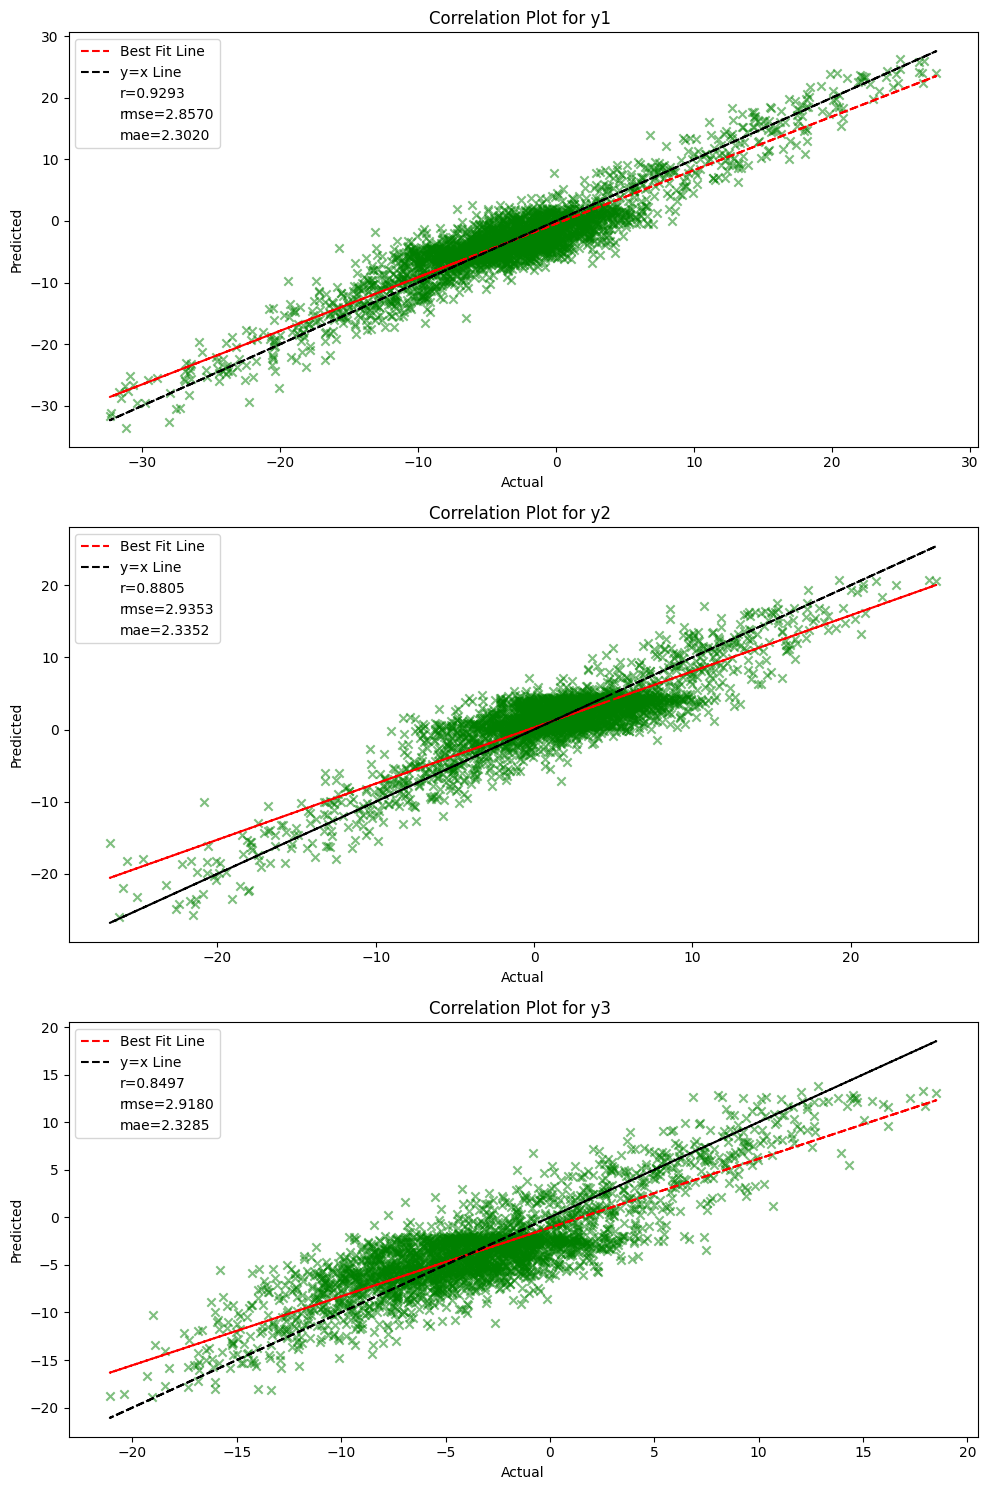

0.2381*X1_norm_2 + -0.2840*X2_norm_2 + 0.0609*X3_norm_2 + -0.5172*X4_norm_2 + 0.5186*X5_norm_2 + 0.6219*X6_norm_2 + -0.4200*X7_norm_2 + 0.4847*X8_norm_2 + -0.3820*X9_norm_2 + -0.2636*X10_norm_2 + -0.0045*X11_norm_2 + -0.0045 = y1_norm_2'
0.6158*X1_norm_2 + 0.5584*X2_norm_2 + -1.0076*X3_norm_2 + 0.0275*X4_norm_2 + 0.0746*X5_norm_2 + -0.0237*X6_norm_2 + 0.3201*X7_norm_2 + -0.4679*X8_norm_2 + 0.3656*X9_norm_2 + -0.7535*X10_norm_2 + 0.0018*X11_norm_2 + 0.0018 = y2_norm_2'
-0.5011*X1_norm_2 + -0.2840*X2_norm_2 + 0.3219*X3_norm_2 + -0.0421*X4_norm_2 + 0.4801*X5_norm_2 + -0.3956*X6_norm_2 + 0.2680*X7_norm_2 + 0.2595*X8_norm_2 + -0.2199*X9_norm_2 + -0.2486*X10_norm_2 + -0.0061*X11_norm_2 + -0.0061 = y3_norm_2'
['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p

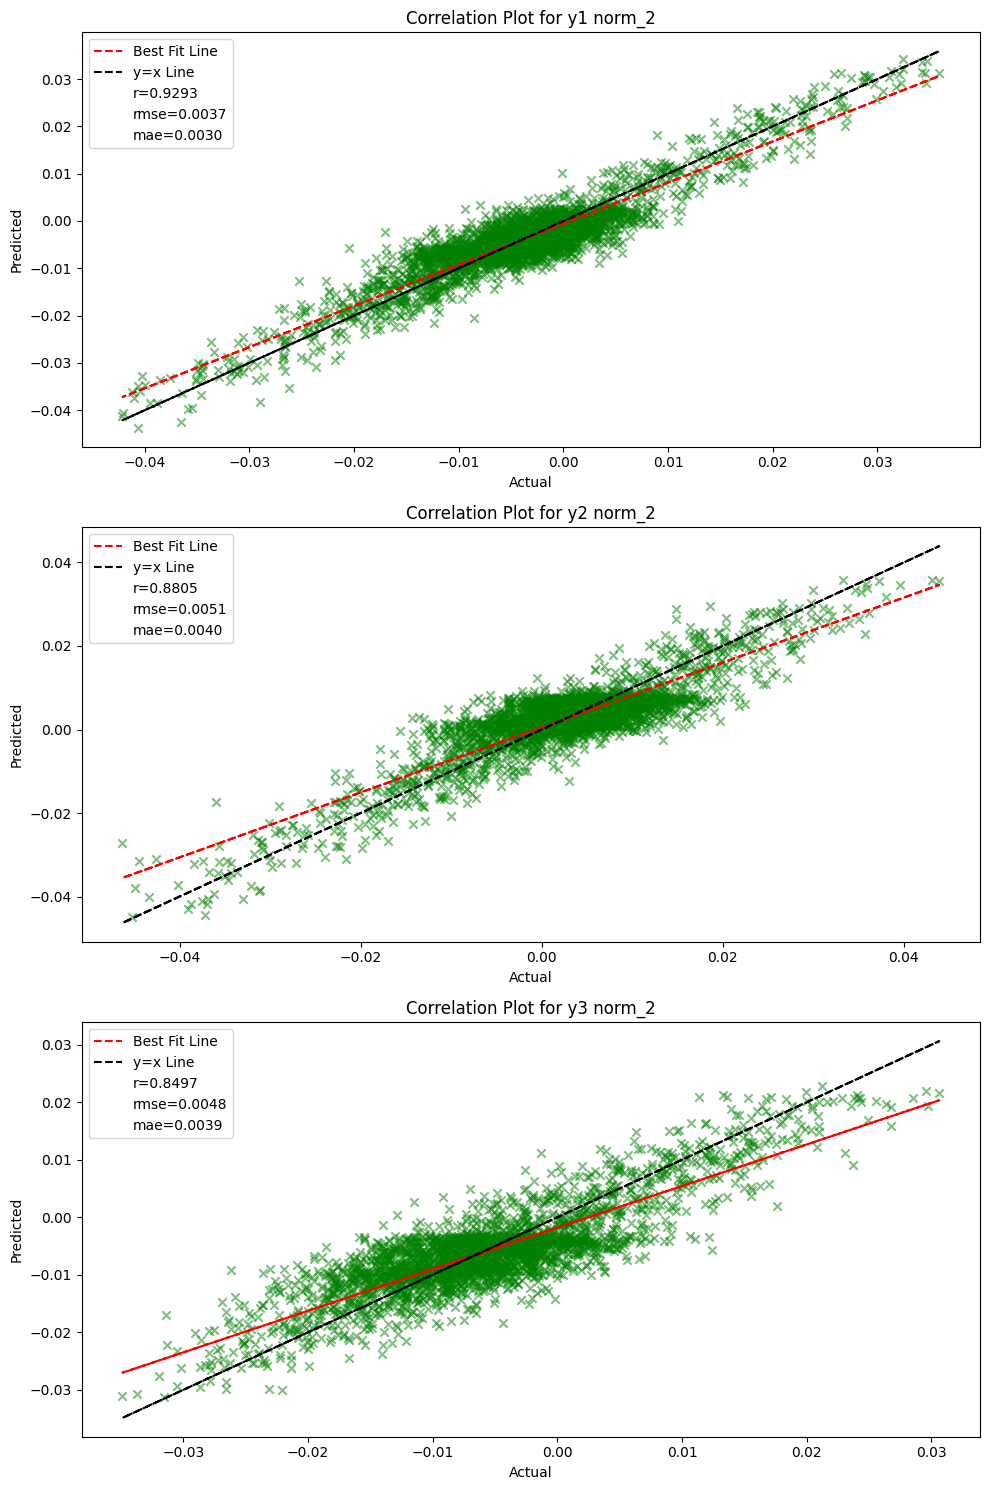

0.2590*X1_norm_zs + -0.2067*X2_norm_zs + 0.0662*X3_norm_zs + -0.5625*X4_norm_zs + 0.3769*X5_norm_zs + 0.6763*X6_norm_zs + -0.4569*X7_norm_zs + 0.5271*X8_norm_zs + -0.4155*X9_norm_zs + -0.2385*X10_norm_zs + -0.0000*X11_norm_zs + -0.0000 = y1_norm_zs'
0.6305*X1_norm_zs + 0.3825*X2_norm_zs + -1.0317*X3_norm_zs + 0.0281*X4_norm_zs + 0.0510*X5_norm_zs + -0.0242*X6_norm_zs + 0.3277*X7_norm_zs + -0.4791*X8_norm_zs + 0.3743*X9_norm_zs + -0.6418*X10_norm_zs + 0.0000*X11_norm_zs + 0.0000 = y2_norm_zs'
-0.5934*X1_norm_zs + -0.2250*X2_norm_zs + 0.3811*X3_norm_zs + -0.0499*X4_norm_zs + 0.3798*X5_norm_zs + -0.4684*X6_norm_zs + 0.3174*X7_norm_zs + 0.3073*X8_norm_zs + -0.2604*X9_norm_zs + -0.2449*X10_norm_zs + -0.0000*X11_norm_zs + -0.0000 = y3_norm_zs'
['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.0

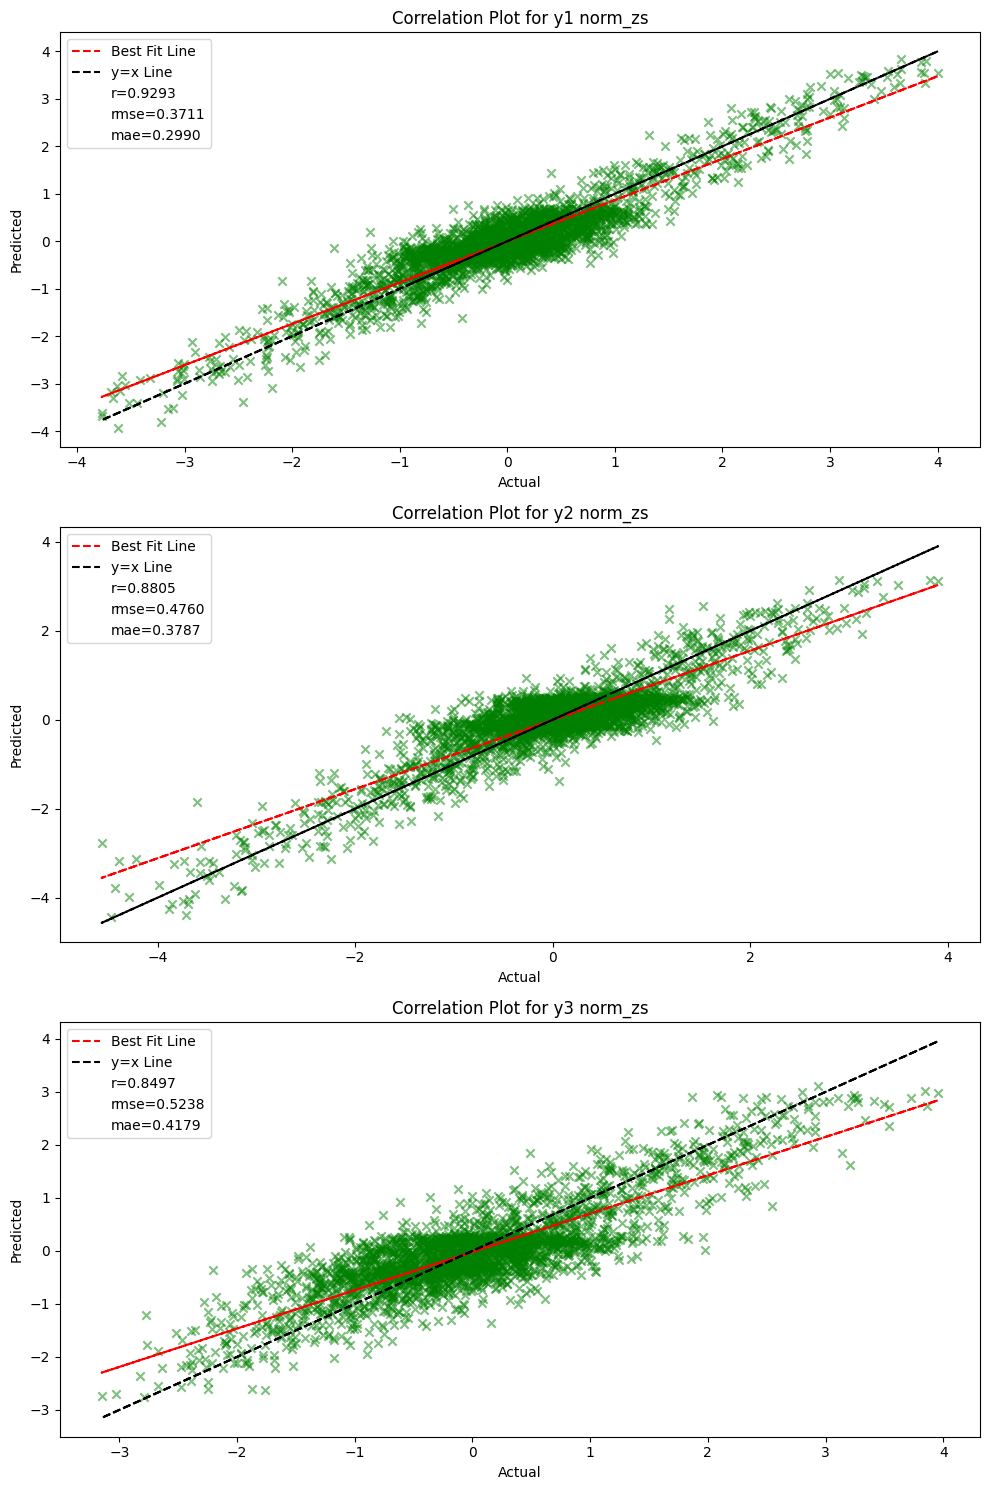

In [11]:
# Display the calculated coefficients
theta = get_theta(X_train, y_train)
print_poly(theta)
plot_y(X_test, y_test, theta)

# Display the calculated coefficients
theta_norm2 = get_theta(X_train_norm_2, y_train_norm_2)
print_poly(theta_norm2, "norm_2")
plot_y(X_test_norm_2, y_test_norm_2, theta_norm2, "norm_2")

# Display the calculated coefficients
theta_norm_zs = get_theta(X_train_norm_zs, y_train_norm_zs)
print_poly(theta_norm_zs, "norm_zs")
plot_y(X_test_norm_zs, y_test_norm_zs, theta_norm_zs, "norm_zs")

Emprical Risk(Training) at epoch 1: 106.1780230101188 | Emprical Risk(Validation) at epoch 1: 77.08869673174803
Emprical Risk(Training) at epoch 51: 15.622486636323943 | Emprical Risk(Validation) at epoch 51: 15.695246423642025
Emprical Risk(Training) at epoch 101: 13.79802110960436 | Emprical Risk(Validation) at epoch 101: 13.94397240228505
Emprical Risk(Training) at epoch 151: 13.156561334485247 | Emprical Risk(Validation) at epoch 151: 13.31521868371553
Emprical Risk(Training) at epoch 201: 12.856634476834115 | Emprical Risk(Validation) at epoch 201: 13.016701203416243
Emprical Risk(Training) at epoch 251: 12.713234996703779 | Emprical Risk(Validation) at epoch 251: 12.872079027591406
Emprical Risk(Training) at epoch 301: 12.644462985917176 | Emprical Risk(Validation) at epoch 301: 12.801629437091869
Emprical Risk(Training) at epoch 351: 12.61142621071786 | Emprical Risk(Validation) at epoch 351: 12.767084923043331
Emprical Risk(Training) at epoch 391: 12.597854143057457 | Emprical 

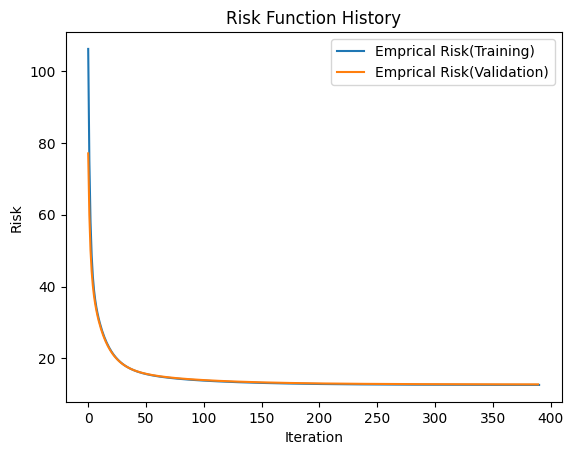

2.1991*X1 + -2.5081*X2 + 0.4658*X3 + -4.6635*X4 + 4.1663*X5 + 3.8747*X6 + -4.7007*X7 + 4.6183*X8 + -3.6527*X9 + -2.0586*X10 + -3.3497*X11 + -3.3497 = y1'
4.2785*X1 + 3.4052*X2 + -4.8853*X3 + 0.1383*X4 + 0.3475*X5 + -0.0853*X6 + 2.7006*X7 + -3.3956*X8 + 2.7003*X9 + -4.6036*X10 + 1.1886*X11 + 1.1886 = y2'
-3.6483*X1 + -1.9940*X2 + 1.5740*X3 + -0.3209*X4 + 3.0169*X5 + -2.0356*X6 + 2.3656*X7 + 1.9783*X8 + -1.7104*X9 + -1.5073*X10 + -3.5381*X11 + -3.5381 = y3'
['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']


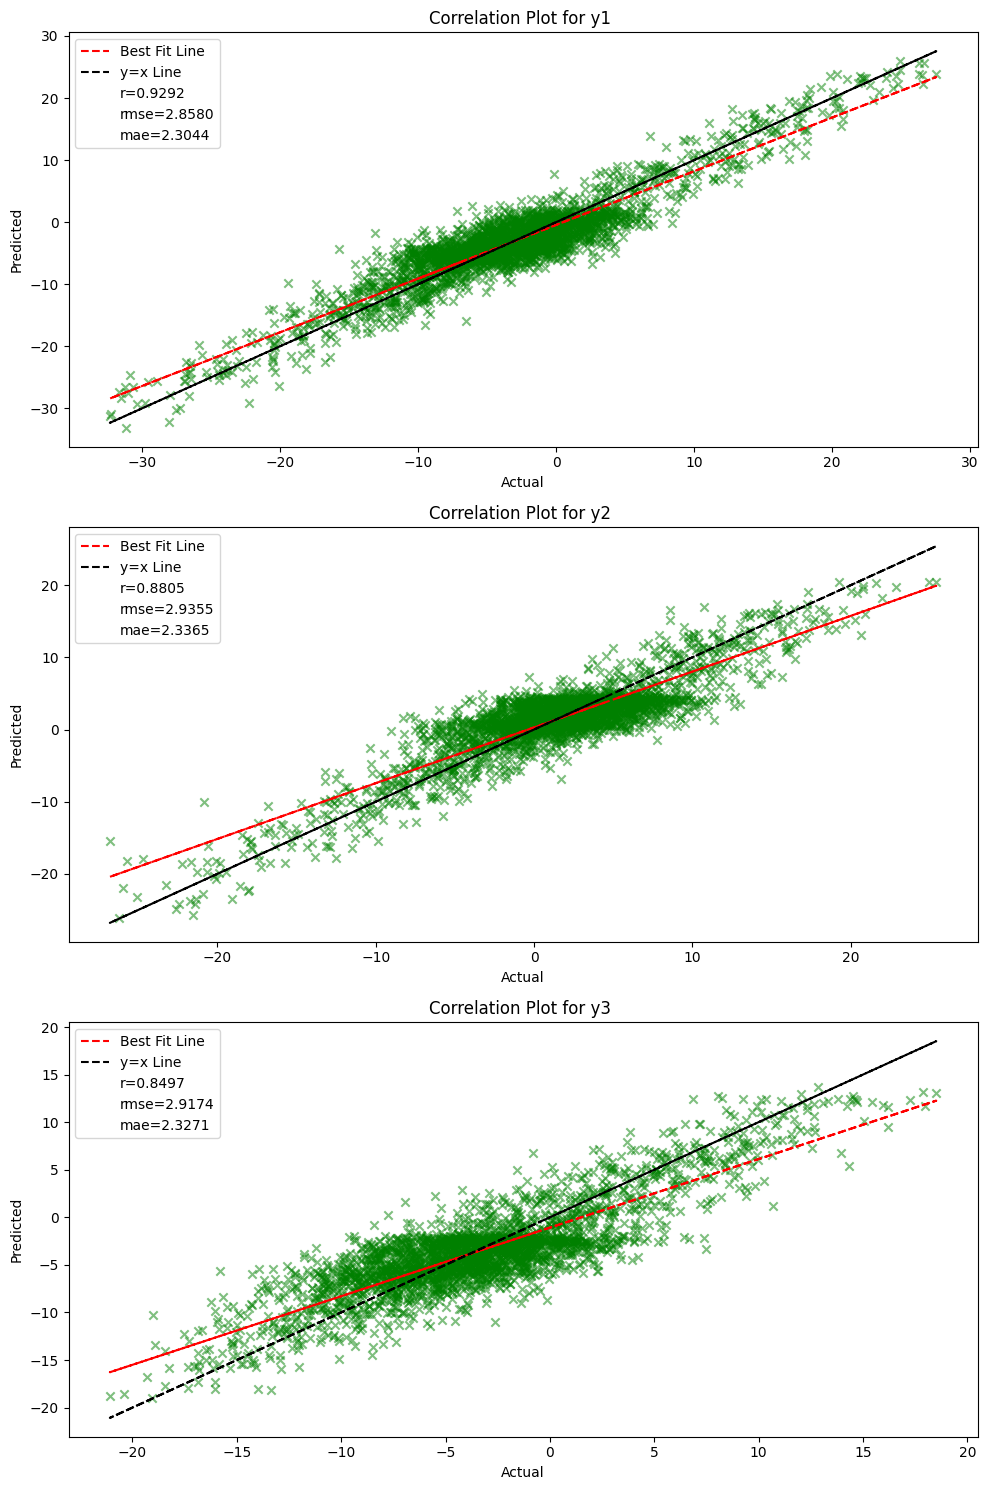

Emprical Risk(Training) at epoch 1: 0.4573358353981075 | Emprical Risk(Validation) at epoch 1: 0.37071252554763223
Emprical Risk(Training) at epoch 29: 0.0027420504903065846 | Emprical Risk(Validation) at epoch 29: 0.0027420504903065846


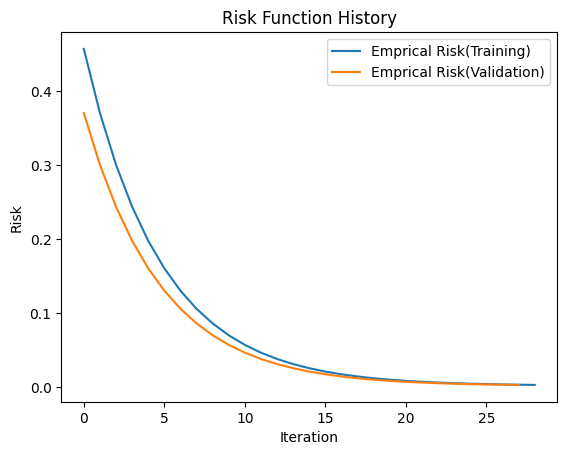

0.9749*X1_norm_2 + 0.9580*X2_norm_2 + 0.7694*X3_norm_2 + 0.9928*X4_norm_2 + 0.6219*X5_norm_2 + 0.3674*X6_norm_2 + 0.8923*X7_norm_2 + 0.4655*X8_norm_2 + 0.3404*X9_norm_2 + 0.9135*X10_norm_2 + -0.0148*X11_norm_2 + -0.0148 = y1_norm_2'
0.6158*X1_norm_2 + 0.2033*X2_norm_2 + 0.8662*X3_norm_2 + 0.0114*X4_norm_2 + 0.4644*X5_norm_2 + 0.0253*X6_norm_2 + 0.8847*X7_norm_2 + 0.5118*X8_norm_2 + 0.1874*X9_norm_2 + 0.5331*X10_norm_2 + 0.0259*X11_norm_2 + 0.0259 = y2_norm_2'
0.9354*X1_norm_2 + 0.3055*X2_norm_2 + 0.5184*X3_norm_2 + 0.2993*X4_norm_2 + 0.1111*X5_norm_2 + 0.6425*X6_norm_2 + 0.6994*X7_norm_2 + 0.1367*X8_norm_2 + 0.8205*X9_norm_2 + 0.7234*X10_norm_2 + 0.0242*X11_norm_2 + 0.0242 = y3_norm_2'
['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']

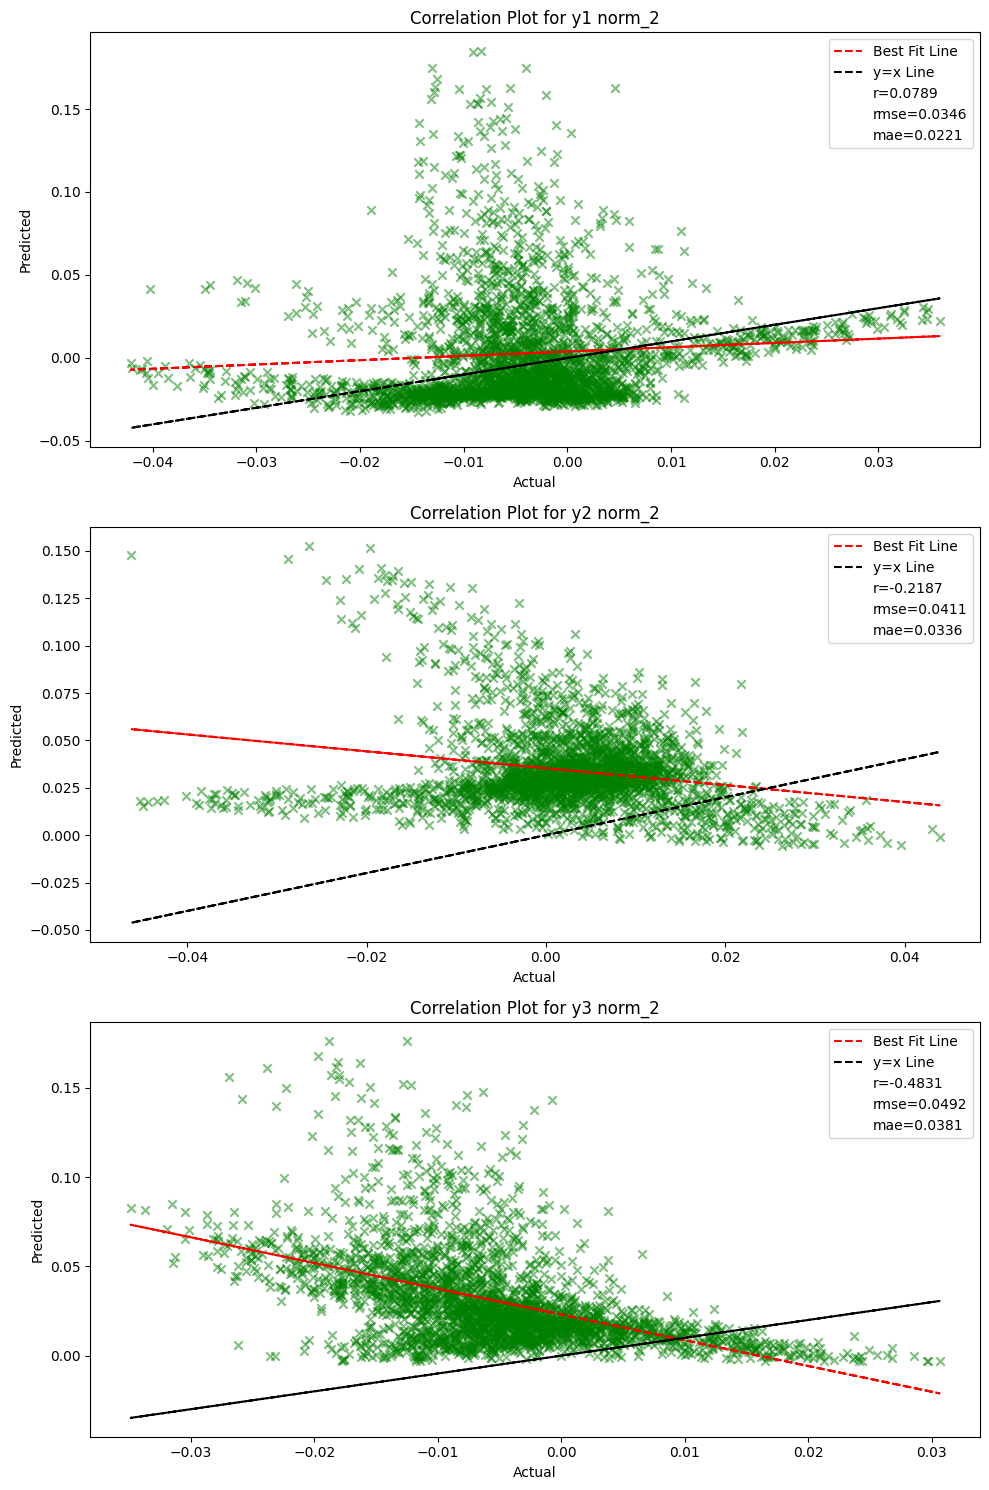

Emprical Risk(Training) at epoch 1: 11.253079659263097 | Emprical Risk(Validation) at epoch 1: 7.522891355102479
Emprical Risk(Training) at epoch 51: 0.392218465854239 | Emprical Risk(Validation) at epoch 51: 0.39725656692923794
Emprical Risk(Training) at epoch 101: 0.34599467492275265 | Emprical Risk(Validation) at epoch 101: 0.3500584288221993
Emprical Risk(Training) at epoch 139: 0.33269226180569467 | Emprical Risk(Validation) at epoch 139: 0.3361884876309791


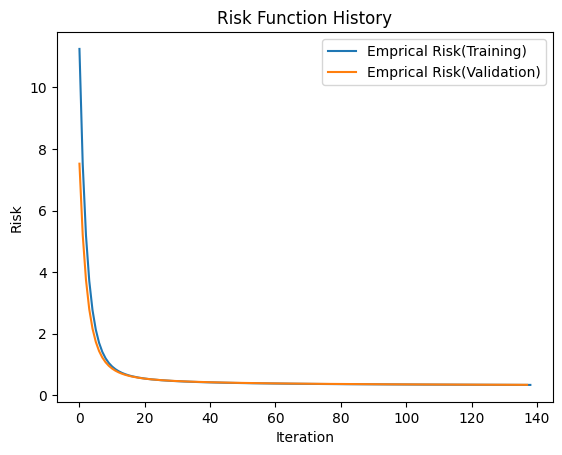

0.1313*X1_norm_zs + -0.1940*X2_norm_zs + 0.1772*X3_norm_zs + -0.4117*X4_norm_zs + 0.3881*X5_norm_zs + 0.5482*X6_norm_zs + -0.4564*X7_norm_zs + 0.4994*X8_norm_zs + -0.3942*X9_norm_zs + -0.2555*X10_norm_zs + 0.0000*X11_norm_zs + 0.0000 = y1_norm_zs'
0.3525*X1_norm_zs + 0.3673*X2_norm_zs + -0.7881*X3_norm_zs + 0.0044*X4_norm_zs + 0.0356*X5_norm_zs + -0.0093*X6_norm_zs + 0.3261*X7_norm_zs + -0.4681*X8_norm_zs + 0.4192*X9_norm_zs + -0.6203*X10_norm_zs + 0.0000*X11_norm_zs + 0.0000 = y2_norm_zs'
-0.2885*X1_norm_zs + -0.2483*X2_norm_zs + 0.1162*X3_norm_zs + -0.0665*X4_norm_zs + 0.3568*X5_norm_zs + -0.4501*X6_norm_zs + 0.3189*X7_norm_zs + 0.3043*X8_norm_zs + -0.3118*X9_norm_zs + -0.2118*X10_norm_zs + 0.0000*X11_norm_zs + 0.0000 = y3_norm_zs'
['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 

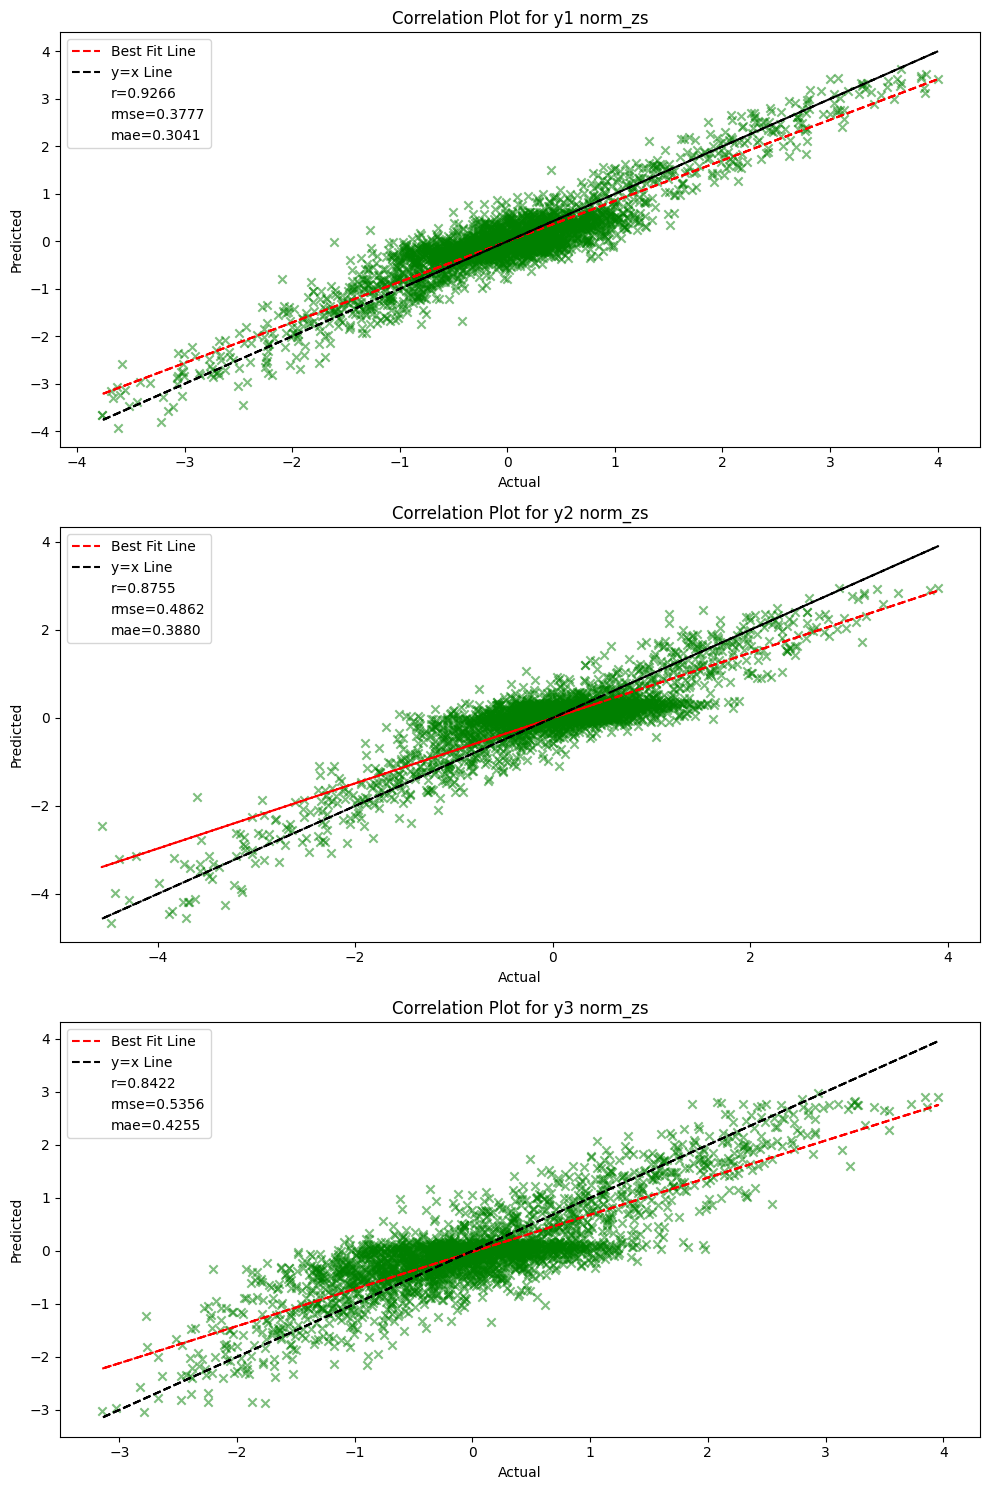

In [12]:
theta_gd, train_losses, val_losses = grad_desc_sq_err(X_train, y_train, X_val, y_val)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd)
plot_y(X_test, y_test, theta_gd)

theta_gd_norm_2, train_losses, val_losses = grad_desc_sq_err(
    X_train_norm_2, y_train_norm_2, X_train_norm_2, y_train_norm_2)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_norm_2, "norm_2")
plot_y(X_test_norm_2, y_test_norm_2, theta_gd_norm_2, "norm_2")

theta_gd_norm_zs, train_losses, val_losses = grad_desc_sq_err(
    X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_norm_zs, "norm_zs")
plot_y(X_test_norm_zs, y_test_norm_zs, theta_gd_norm_zs, "norm_zs")

Emprical Risk(Training) at epoch 1: 86.91908742135185 | Emprical Risk(Validation) at epoch 1: 63.438937150954324
Emprical Risk(Training) at epoch 51: 24.17485647076876 | Emprical Risk(Validation) at epoch 51: 24.38309328558076
Emprical Risk(Training) at epoch 101: 25.137686007631523 | Emprical Risk(Validation) at epoch 101: 25.369864867175338
Emprical Risk(Training) at epoch 151: 26.018211084148582 | Emprical Risk(Validation) at epoch 151: 26.25338383082317
Emprical Risk(Training) at epoch 201: 26.83500434109754 | Emprical Risk(Validation) at epoch 201: 27.06781719158822
Emprical Risk(Training) at epoch 251: 27.5337306801214 | Emprical Risk(Validation) at epoch 251: 27.762478465915898
Emprical Risk(Training) at epoch 301: 28.087170242083204 | Emprical Risk(Validation) at epoch 301: 28.311904117710796
Emprical Risk(Training) at epoch 351: 28.50471520700747 | Emprical Risk(Validation) at epoch 351: 28.726120263477203
Emprical Risk(Training) at epoch 393: 28.76797052797304 |  Emprical Ris

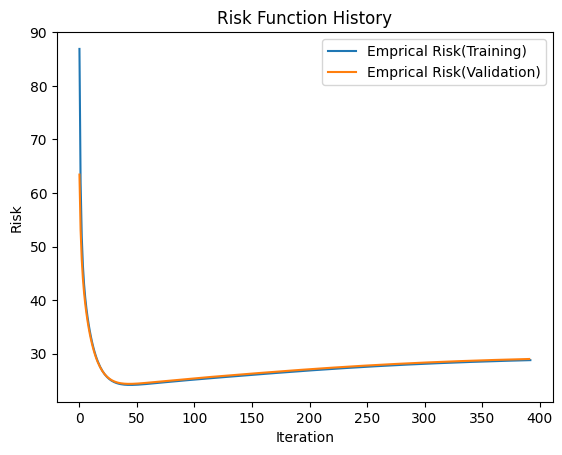

['p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']


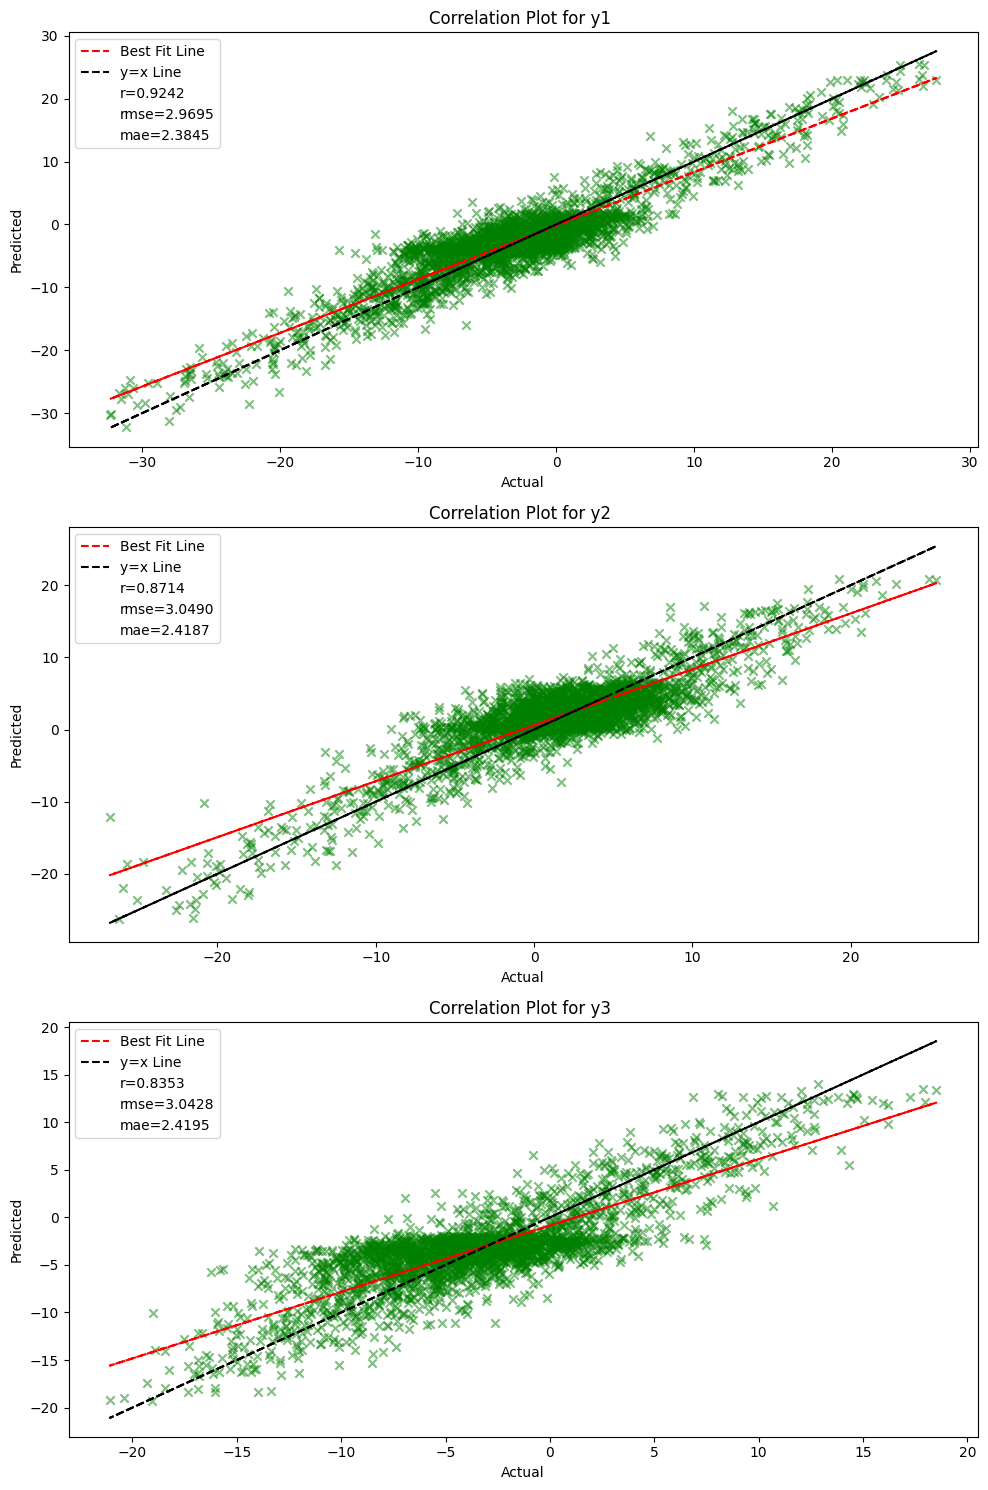

Emprical Risk(Training) at epoch 1: 1.0596208065991959 | Emprical Risk(Validation) at epoch 1: 0.6569215350753266
Emprical Risk(Training) at epoch 26: 0.1486393813057431 |  Emprical Risk(Validation) at epoch 26: 0.1486393813057431
-0.1231*X1_norm_2 + -0.2042*X2_norm_2 + 0.5035*X3_norm_2 + -0.0163*X4_norm_2 + 0.5402*X5_norm_2 + 0.5704*X6_norm_2 + 0.5211*X7_norm_2 + 0.1538*X8_norm_2 + 0.2149*X9_norm_2 + 0.1075*X10_norm_2 + 0.0194*X11_norm_2 + 0.0194 = y1_norm_2'
-0.2162*X1_norm_2 + 0.1589*X2_norm_2 + 0.3548*X3_norm_2 + -0.0360*X4_norm_2 + 0.0425*X5_norm_2 + 0.5643*X6_norm_2 + 0.1566*X7_norm_2 + 0.1706*X8_norm_2 + -0.0660*X9_norm_2 + -0.1955*X10_norm_2 + 0.0296*X11_norm_2 + 0.0296 = y2_norm_2'
-0.3236*X1_norm_2 + -0.3213*X2_norm_2 + -0.3236*X3_norm_2 + -0.3236*X4_norm_2 + -0.3212*X5_norm_2 + -0.3236*X6_norm_2 + -0.3235*X7_norm_2 + -0.3235*X8_norm_2 + -0.3236*X9_norm_2 + -0.3219*X10_norm_2 + -0.0307*X11_norm_2 + -0.0307 = y3_norm_2'


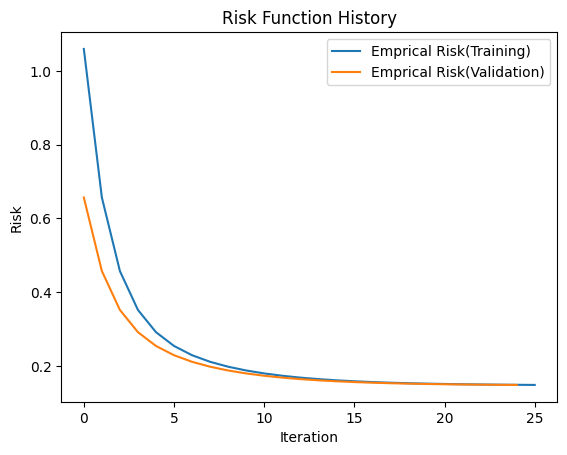

['p<0.01', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.01', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']


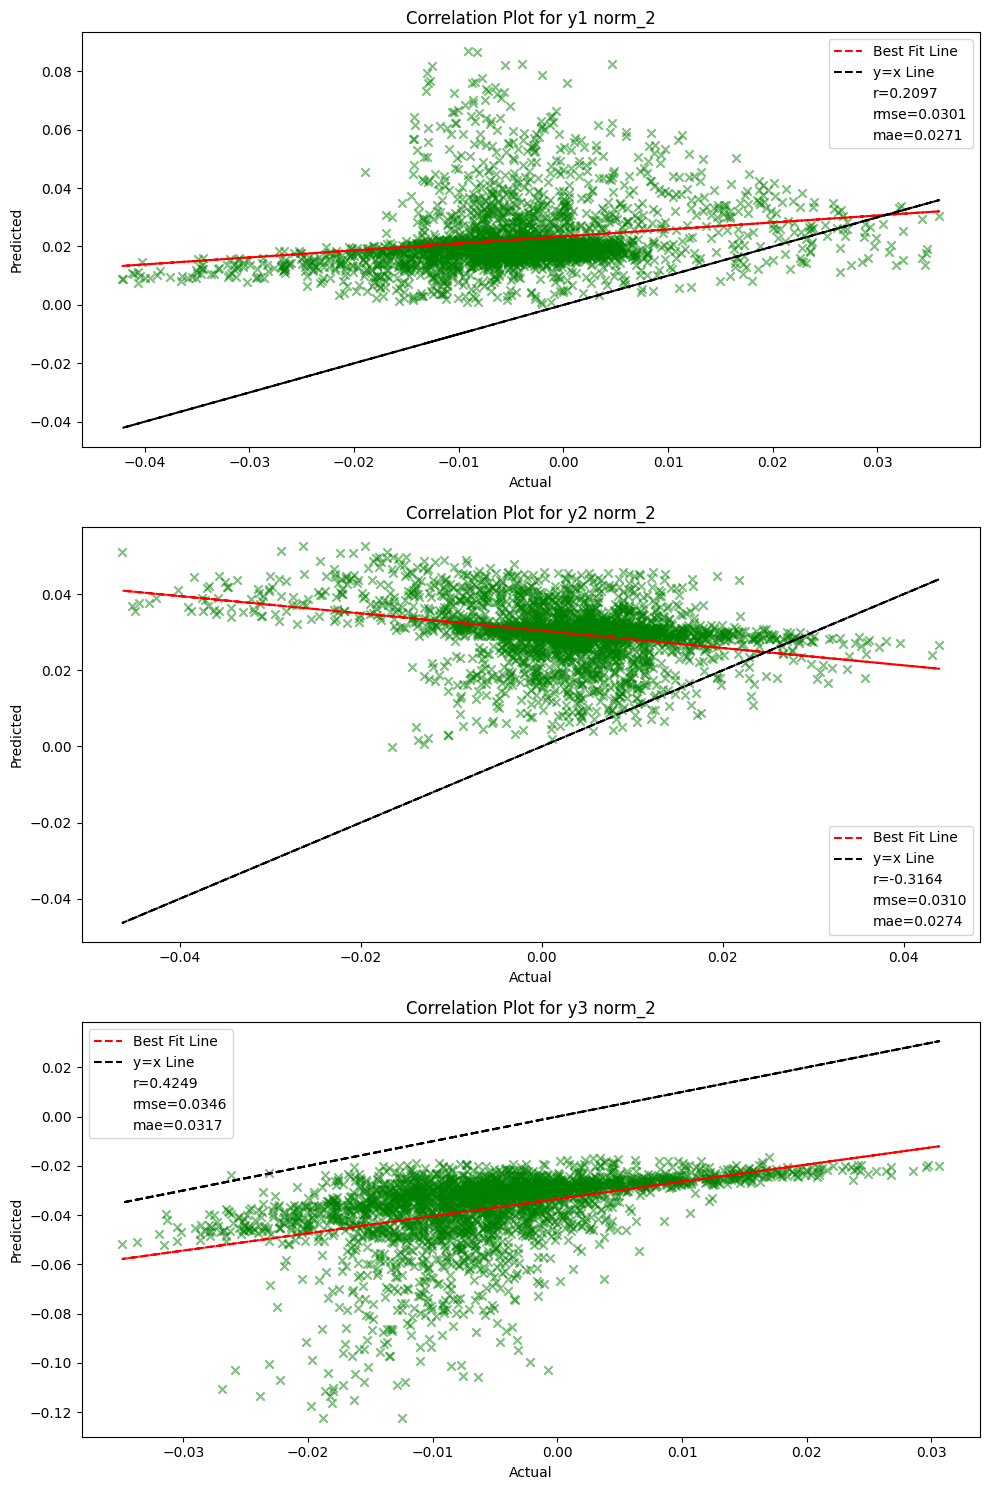

Emprical Risk(Training) at epoch 1: 4.981817034920996 | Emprical Risk(Validation) at epoch 1: 2.536021309913752
Emprical Risk(Training) at epoch 51: 0.516982132402617 | Emprical Risk(Validation) at epoch 51: 0.5219671998964619
Emprical Risk(Training) at epoch 101: 0.5251523879607409 | Emprical Risk(Validation) at epoch 101: 0.5296961890886169
Emprical Risk(Training) at epoch 128: 0.5342722549666319 |  Emprical Risk(Validation) at epoch 128: 0.5382842039102463
0.2342*X1_norm_zs + -0.1573*X2_norm_zs + 0.1037*X3_norm_zs + -0.2890*X4_norm_zs + 0.4246*X5_norm_zs + 0.4581*X6_norm_zs + -0.4258*X7_norm_zs + 0.4968*X8_norm_zs + -0.3936*X9_norm_zs + -0.2701*X10_norm_zs + 0.0284*X11_norm_zs + 0.0284 = y1_norm_zs'
0.3297*X1_norm_zs + 0.3860*X2_norm_zs + -0.7498*X3_norm_zs + 0.0088*X4_norm_zs + 0.0556*X5_norm_zs + 0.0075*X6_norm_zs + 0.3551*X7_norm_zs + -0.4550*X8_norm_zs + 0.4387*X9_norm_zs + -0.6103*X10_norm_zs + 0.0284*X11_norm_zs + 0.0284 = y2_norm_zs'
-0.4083*X1_norm_zs + -0.2079*X2_norm_zs + 

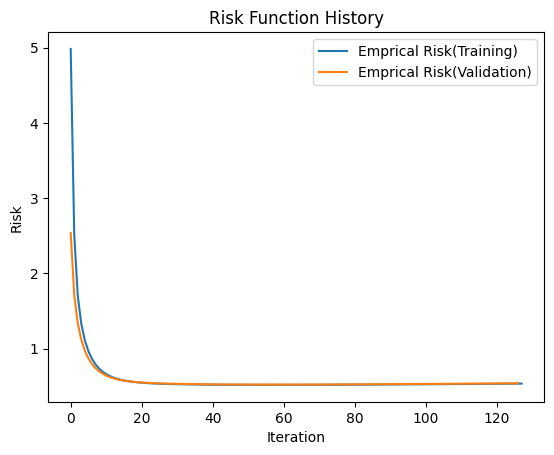

['p<0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']
['p>0.05', 'p>0.05', 'p<0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05', 'p>0.05']


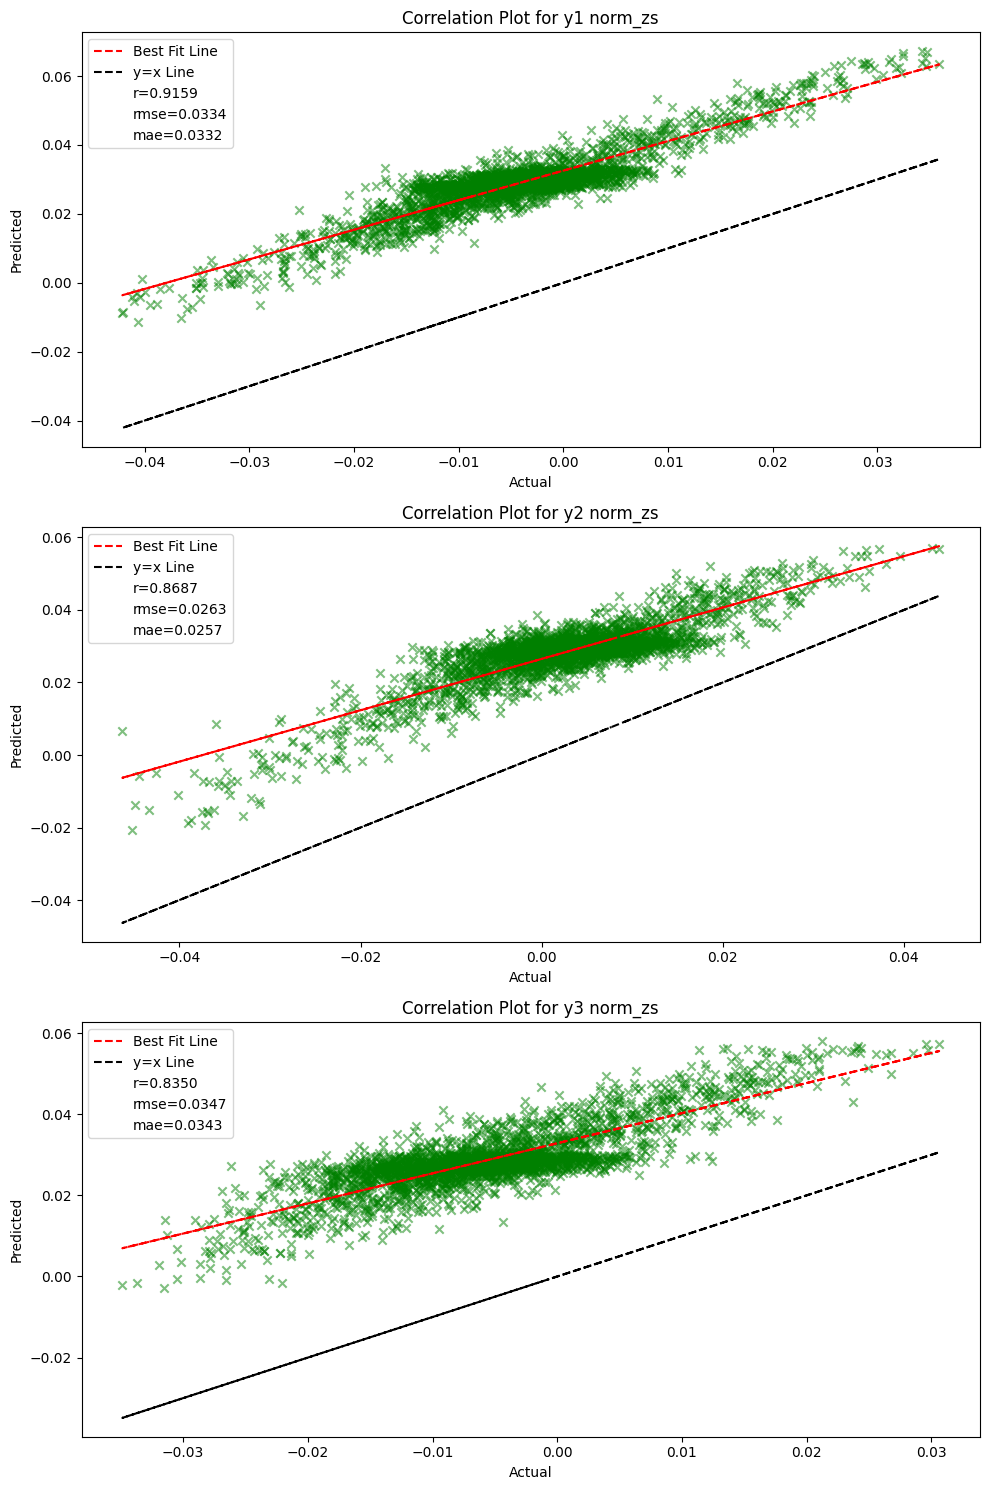

In [13]:
theta_gd_reg, train_losses, val_losses = grad_desc_sq_err_reg(X_train, y_train, X_val, y_val)
print_poly(theta_gd_reg)
plot_train_loss(train_losses, val_losses)
plot_y(X_test, y_test, theta_gd_reg)

theta_gd_reg_norm_2, train_losses, val_losses = grad_desc_sq_err_reg(
    X_train_norm_2, y_train_norm_2, X_train_norm_2, y_train_norm_2)
print_poly(theta_gd_reg_norm_2, "norm_2")
plot_train_loss(train_losses, val_losses)
plot_y(X_test_norm_2, y_test_norm_2, theta_gd_reg_norm_2, "norm_2")

theta_gd_reg_norm_zs, train_losses, val_losses = grad_desc_sq_err_reg(
    X_train_norm_zs, y_train_norm_zs, X_val_norm_zs, y_val_norm_zs)
print_poly(theta_gd_reg_norm_zs, "norm_zs")
plot_train_loss(train_losses, val_losses)
plot_y(X_test_norm_2, y_test_norm_2, theta_gd_reg_norm_zs, "norm_zs")